###### Inicialização

In [2]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from datetime import datetime, date
from IPython.display import Markdown

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

import seaborn as sns
import plotly.graph_objects as go

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
def resultado_shapiro(stat, p):
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (stat, p)))
  # interpretando resultados
  alpha = 0.05
  if p > alpha:
      display(Markdown("**A amostra parece Gaussiana (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A amostra não parece Gaussiana (rejeitamos H0)**'))

# Análise de Séries temporais (Sessão 5)

---

## Pré-processamento (parte 2)

##Transformação de dados

Para realizar uma análise descritiva de séries temporais, devemos procurar:
1. Entender o contexto do problema e da fonte dos dados;
2. Pensar em transformação de dados, para reduzir por exemplo a assimetria dos dados;
3. Investigar a estacionariedade e tentar atingí-la por meio da decomposição dos dados;
4. Ao tornar a série estacionária, devemos partir para analisar a função de autocorrelação;


#### Construindo os dados de exemplo

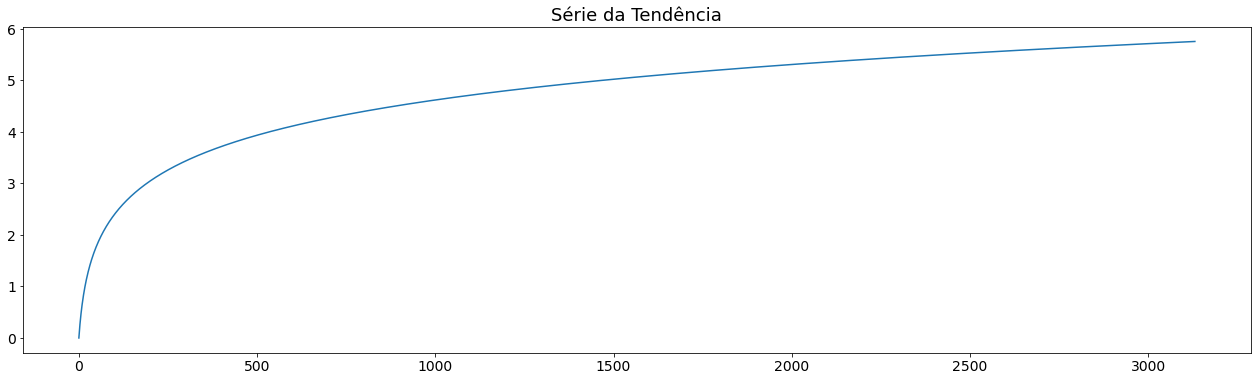

In [6]:
x = np.arange(1, 100 * np.pi, 0.1)
T = pd.Series(np.log(x))
_ = T.plot(kind='line', title="Série da Tendência")

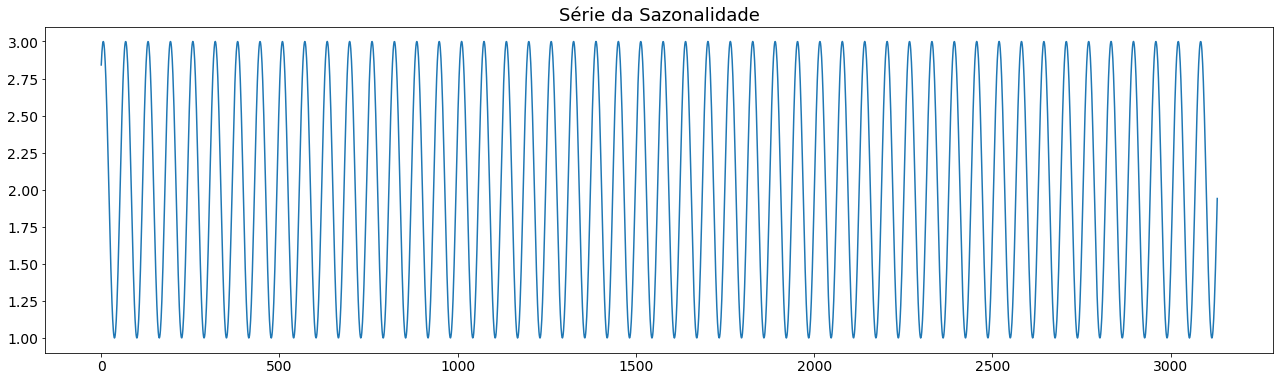

In [7]:
S = pd.Series(np.sin(x)) + 2
_ = S.plot(kind='line', title="Série da Sazonalidade")

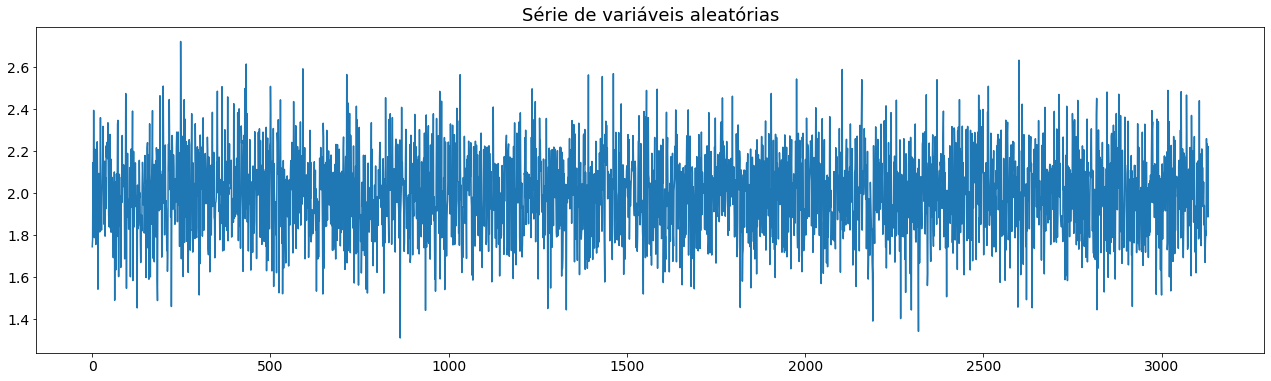

In [8]:
mu = 2
sigma = .2
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)
_ = R.plot(kind='line', title="Série de variáveis aleatórias")

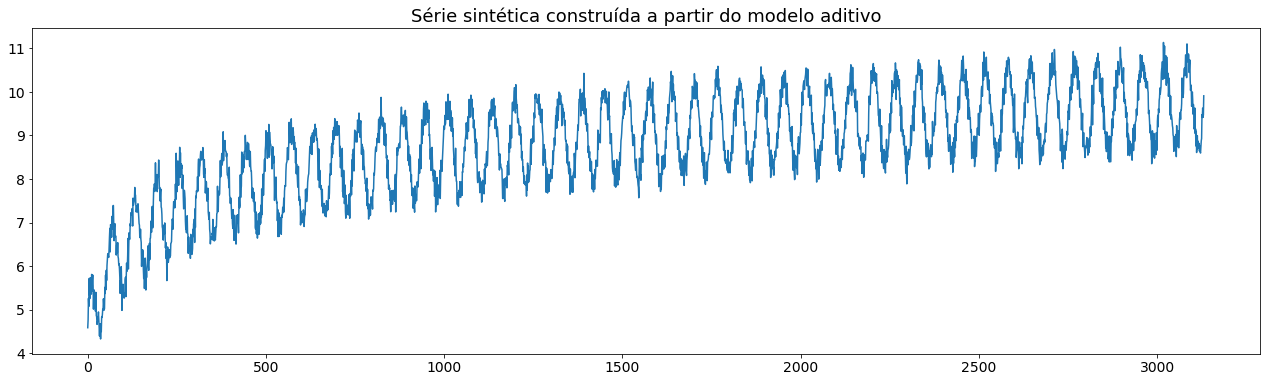

In [9]:
X = T + S + R
_ = X.plot(kind='line', title = "Série sintética construída a partir do modelo aditivo")

---

#### Capturando séries de temperatura

In [10]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

---

### 1. Diferenciação

É uma metodologia simples de **remoção de tendências** e/ou efeitos sazonais. Para tal, utilizamos a equação a seguir para gerar uma nova série a partir da série original:

\begin{align}
Y_t= X_{t + 1} - X_t
\end{align}

##### Exemplificando com dados sintéticos

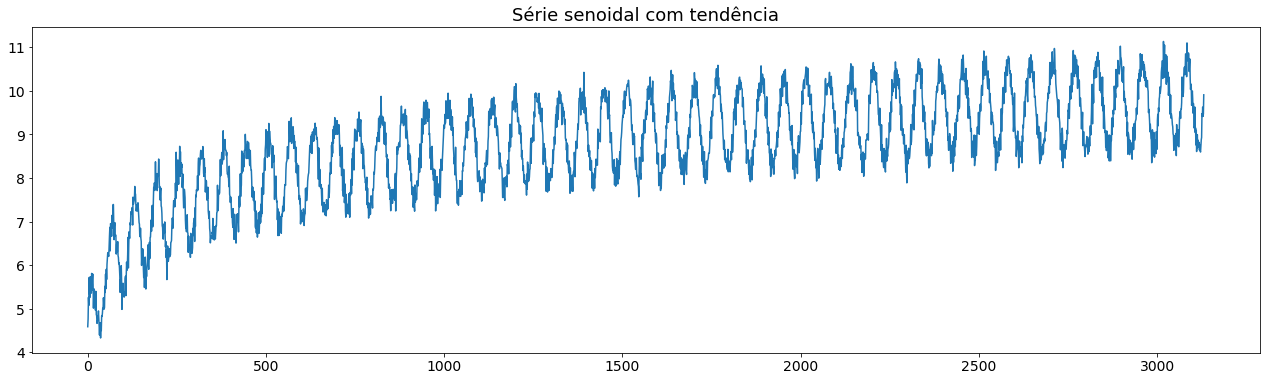

In [11]:
_ = X.plot(kind='line' ,title="Série senoidal com tendência")

In [13]:
stat, p = stats.shapiro(X)

resultado_shapiro(stat, p)

Statistics=0.965, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

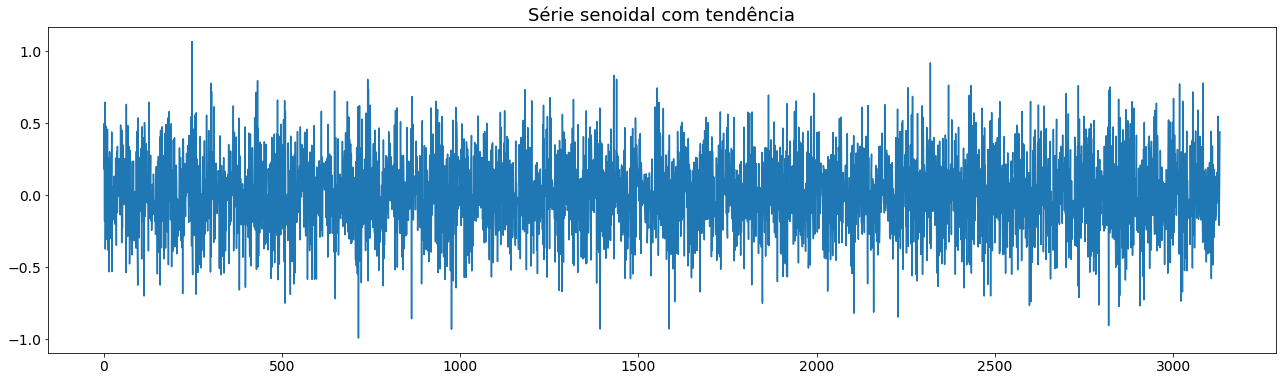

In [14]:
_ = X.diff().plot(kind='line' ,title="Série senoidal com tendência")

In [15]:
X.diff().mean()

0.0017012234411988149

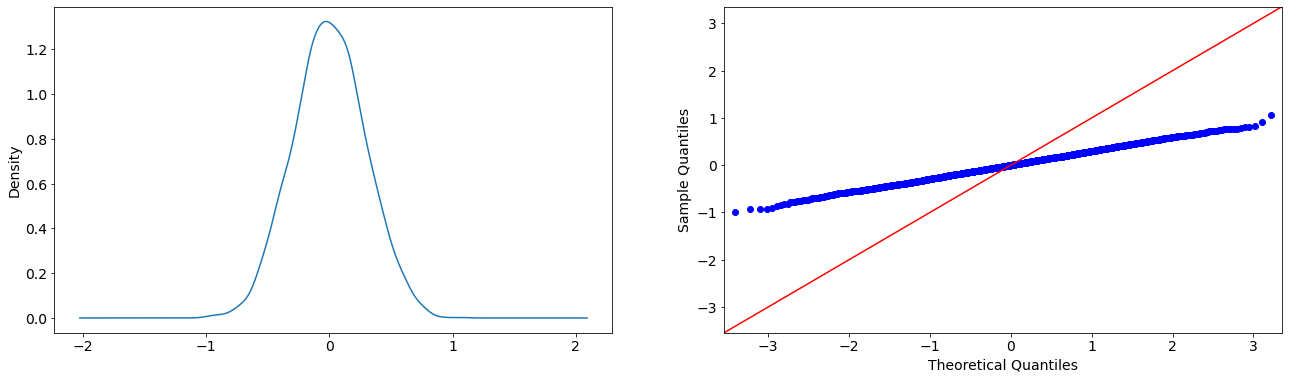

In [16]:
fig, axs = plt.subplots(1,2)
_ = X.diff().plot(kind="kde", ax=axs[0])
sm.qqplot(X.diff(), line ='45', ax=axs[1])
plt.show()

In [17]:
stat, p = stats.shapiro(X.diff()[1:])

resultado_shapiro(stat, p)

Statistics=1.000, p-valor=0.73798025

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

---

##### Exemplo com dados reais

Aplicando a diferenciação na série de câmbio dólar/real

In [18]:
serie_dolar = pdr.get_data_yahoo("USDBRL=X", start="2007-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


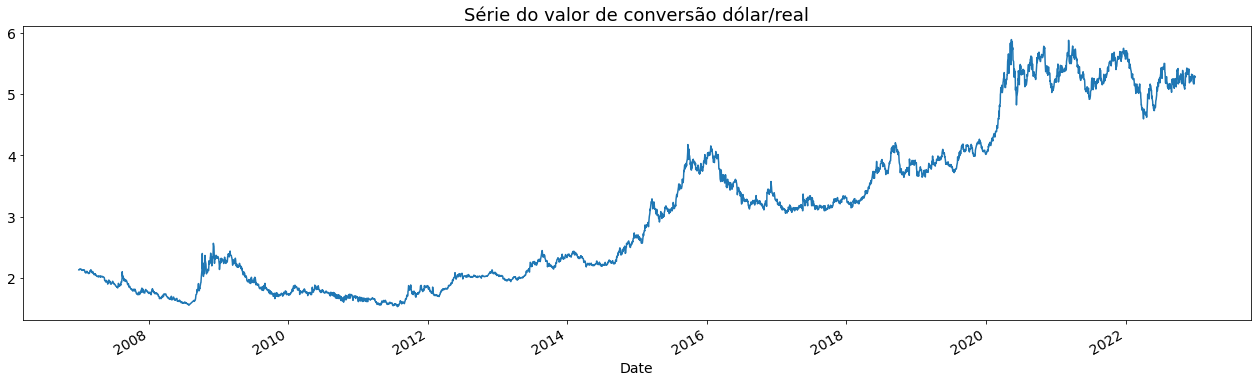

In [19]:
_ = serie_dolar.Close.plot(title="Série do valor de conversão dólar/real")

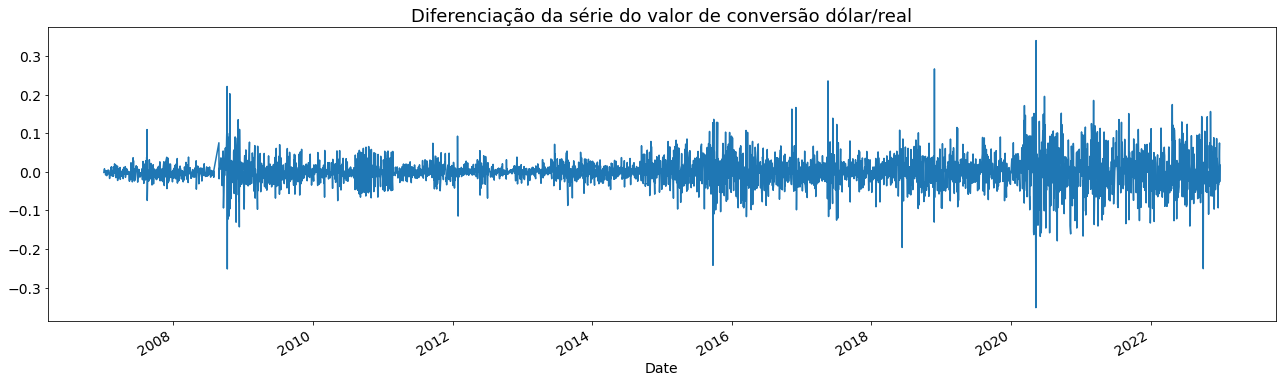

In [20]:
_ = serie_dolar.Close.diff().plot(title="Diferenciação da série do valor de conversão dólar/real")

In [21]:
serie_dolar.Close.diff().mean()

0.0007613767748293669

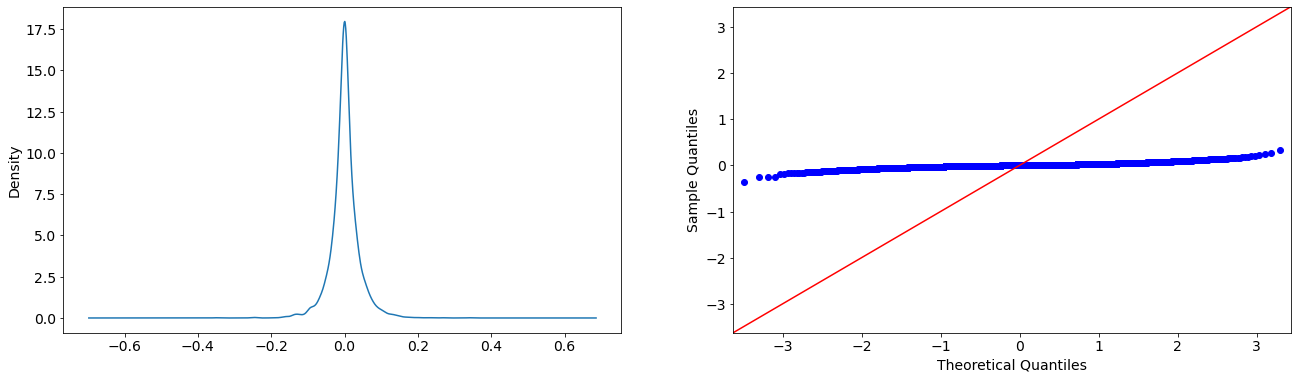

In [22]:
fig, axs = plt.subplots(1,2)
_ = serie_dolar.Close.diff().plot(kind="kde", ax=axs[0])
sm.qqplot(serie_dolar.Close.diff(), line ='45', ax=axs[1])
plt.show()

In [23]:
stat, p = stats.shapiro(serie_dolar.Close.diff()[1:])

resultado_shapiro(stat, p)

Statistics=0.911, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

Aplicando a diferenciação na série de temperatura média de Aracaju

In [24]:
serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

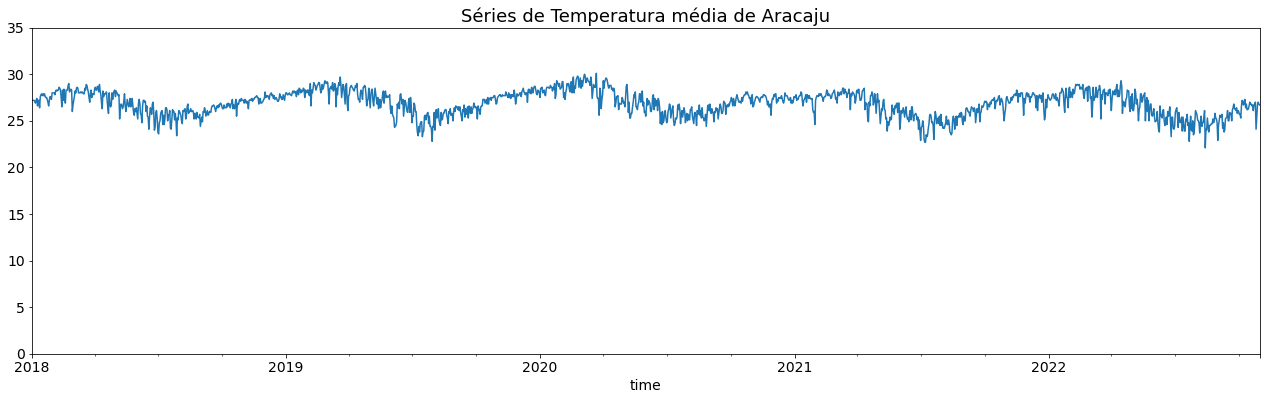

In [25]:
_ = serie_aracaju.tavg.plot(title="Séries de Temperatura média de Aracaju", ylim=(0,35))

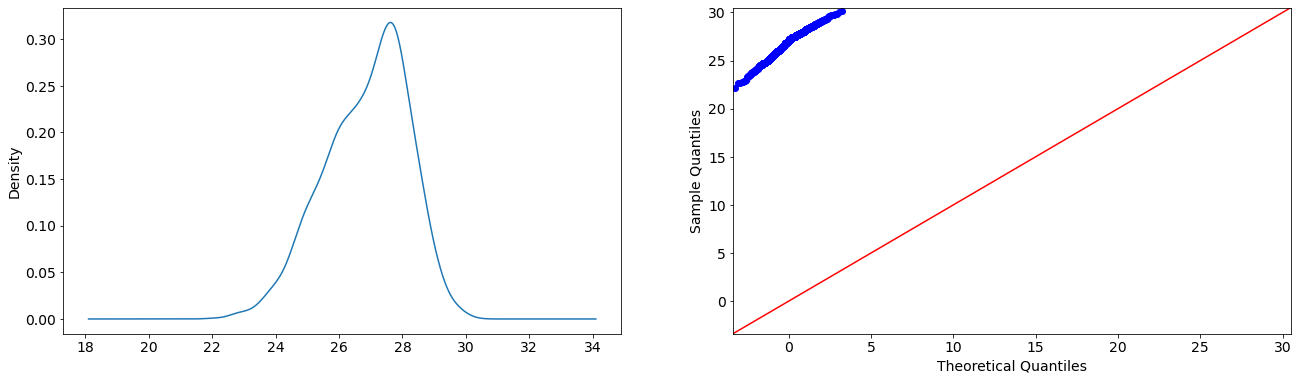

In [26]:
fig, axs = plt.subplots(1,2)
_ = serie_aracaju.tavg.plot(kind="kde", ax=axs[0])
sm.qqplot(serie_aracaju.tavg, line ='45', ax=axs[1])
plt.show()

In [27]:
stat, p = stats.shapiro(serie_aracaju.tavg)

resultado_shapiro(stat, p)

Statistics=0.982, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

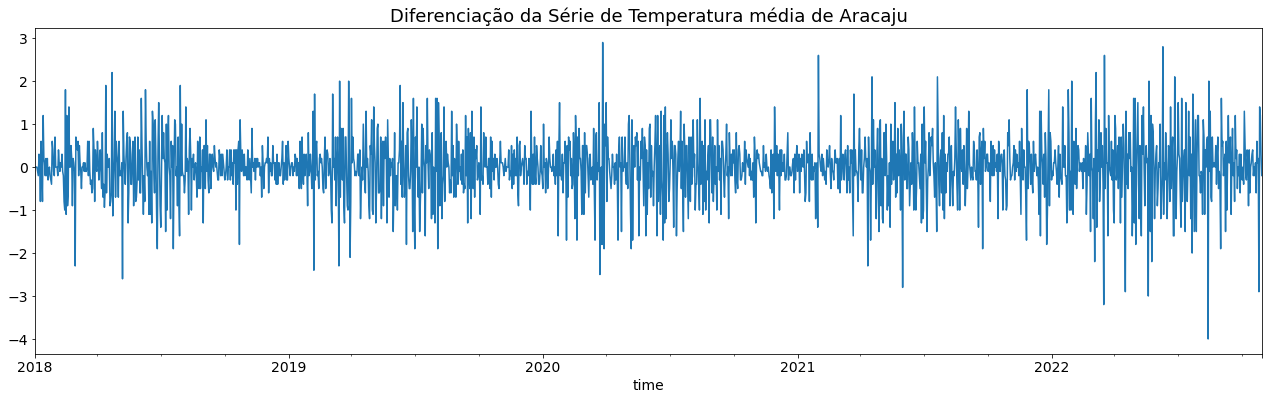

In [28]:
_ = serie_aracaju.tavg.diff().plot(title="Diferenciação da Série de Temperatura média de Aracaju")

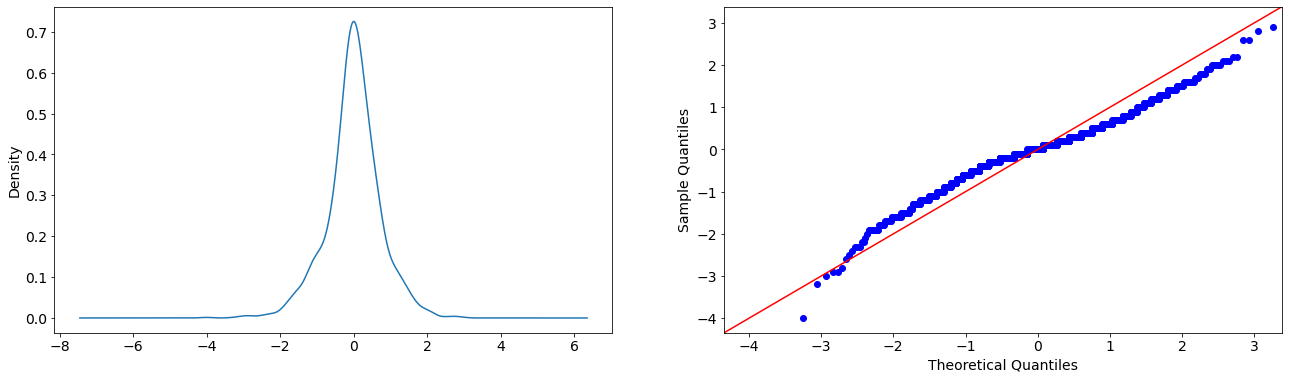

In [29]:
fig, axs = plt.subplots(1,2)
_ = serie_aracaju.tavg.diff()[1:].plot(kind="kde", ax=axs[0])
sm.qqplot(serie_aracaju.tavg.diff()[1:], line ='45', ax=axs[1])
plt.show()

In [30]:
stat, p = stats.shapiro(serie_aracaju.tavg.diff()[1:])

resultado_shapiro(stat, p)

Statistics=0.974, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

---

### 2. Diferenciaçao Log return

$Y_t= \log(X_{t+1}) - \log(X_t)$

##### Exemplificando com dados sintéticos

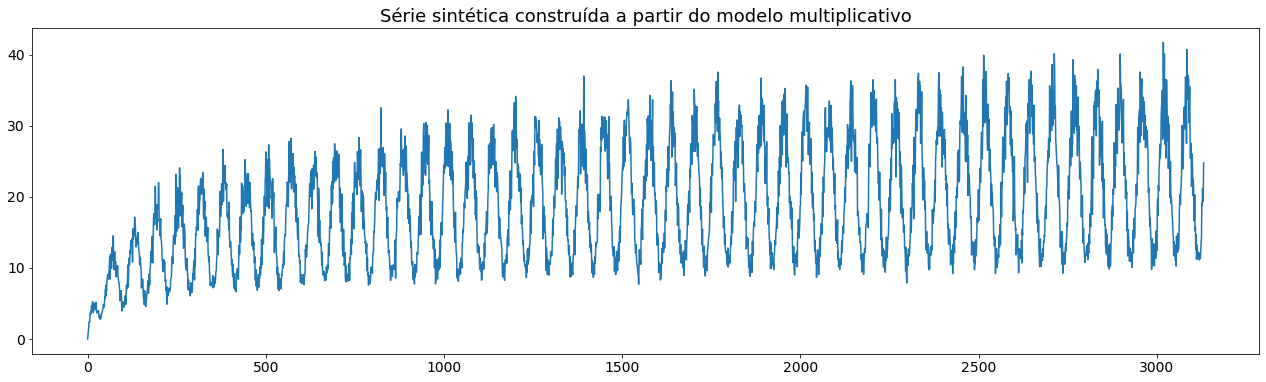

In [31]:
X2 = T * S * R
_ = X2.plot(kind='line', title = "Série sintética construída a partir do modelo multiplicativo")

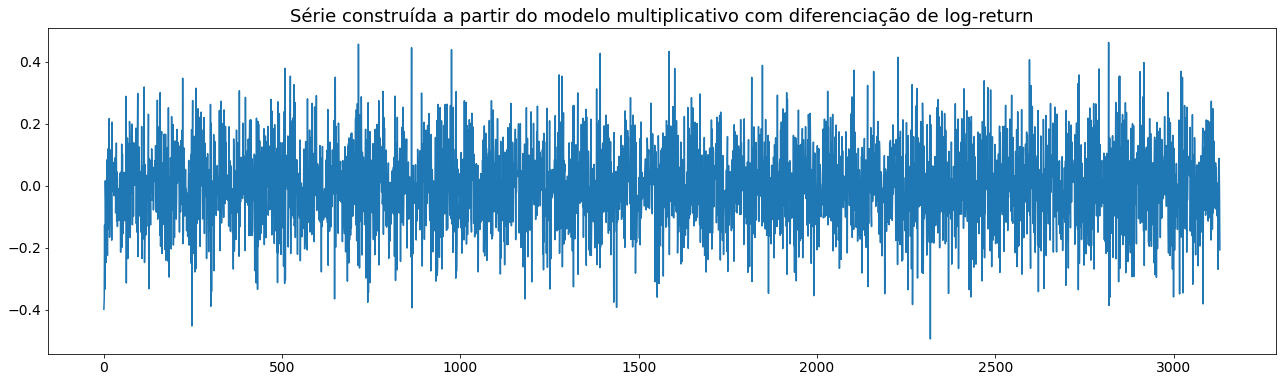

In [32]:
Y2 = (X2.apply(np.log1p) - X2.shift(-1).apply(np.log1p))[:-1]
_ = Y2.plot(kind='line', title = "Série construída a partir do modelo multiplicativo com diferenciação de log-return")

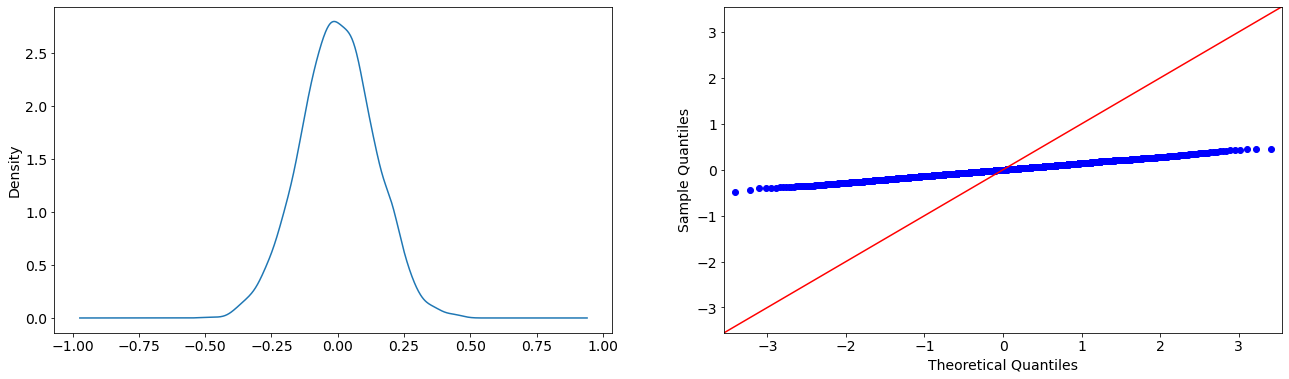

In [33]:
fig, axs = plt.subplots(1,2)
_ = Y2.plot(kind="kde", ax=axs[0])
sm.qqplot(Y2, line ='45', ax=axs[1])
plt.show()

In [34]:
stat, p = stats.shapiro(Y2)

resultado_shapiro(stat, p)

Statistics=1.000, p-valor=0.79773319

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

Como visto na sessão 4, aplicando a transformação de log, convertemos o modelo multiplicativo para um modelo aditivo:
\begin{align}
\log(X_t) &= T_t + S_t + R_t
\end{align}

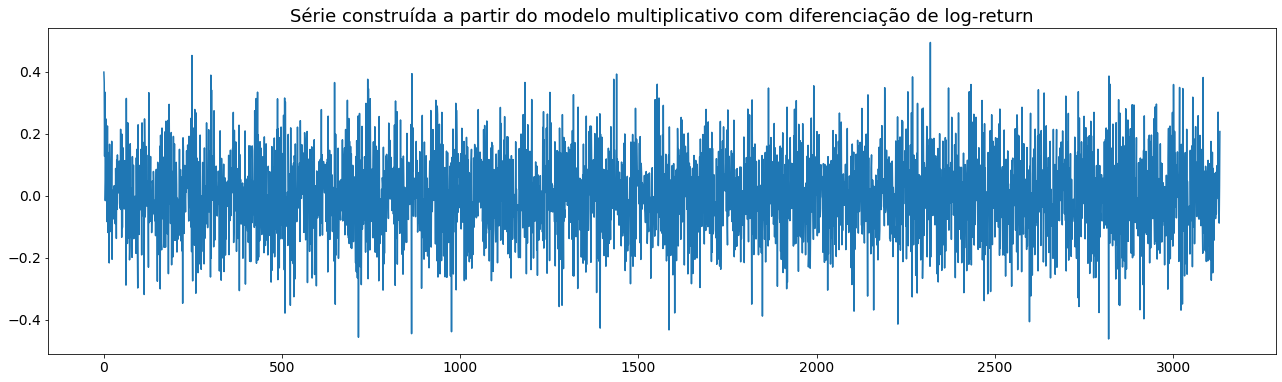

In [35]:
_ = X2.apply(np.log1p).diff().plot(kind='line', title = "Série construída a partir do modelo multiplicativo com diferenciação de log-return")

O que acontece se aplicarmos a diferenciação simples em uma série construída a partir do modelo multiplicativo?

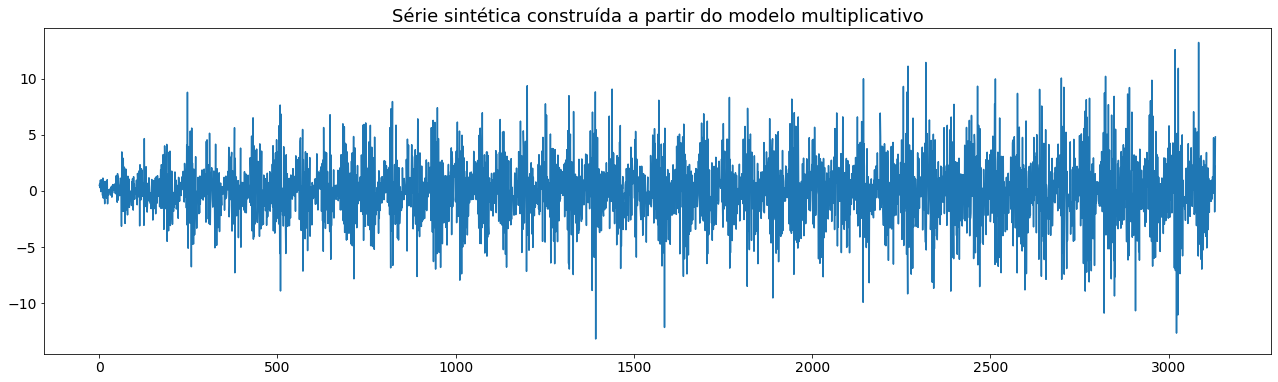

In [36]:
_ = X2.diff().plot(kind='line', title = "Série sintética construída a partir do modelo multiplicativo")

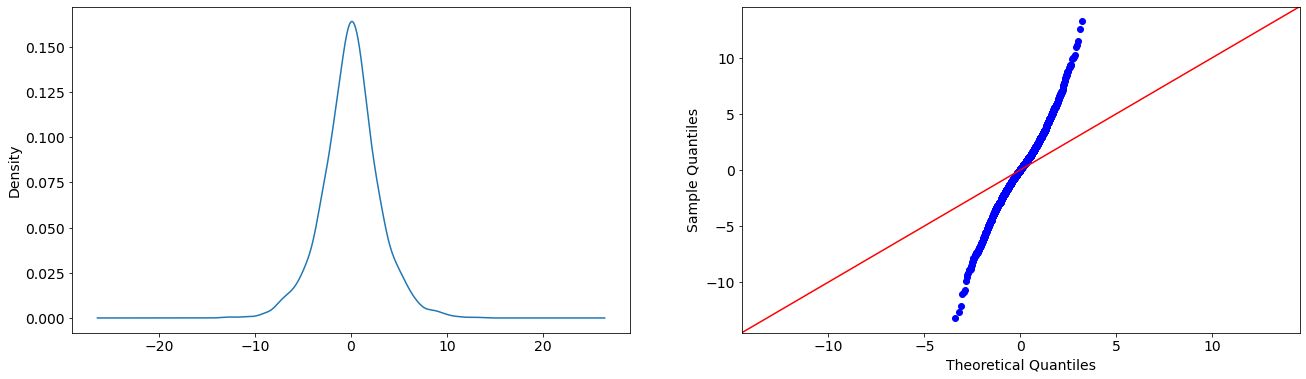

In [37]:
fig, axs = plt.subplots(1,2)
_ = X2.diff().plot(kind="kde", ax=axs[0])
sm.qqplot(X2.diff(), line ='45', ax=axs[1])
plt.show()

In [38]:
stat, p = stats.shapiro(X2.diff()[1:])

resultado_shapiro(stat, p)

Statistics=0.988, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

##### Exemplificando com dados reais

[![Gráfico](https://miro.medium.com/max/640/0*4NiXjnaaxyVKjqjP.webp)](https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693)

Explicado no artigo:
https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693

Dados se encontram em:
https://www.kaggle.com/datasets/rakannimer/air-passengers


---
Mas vamos testar com os dados que estamos utilizando no curso...

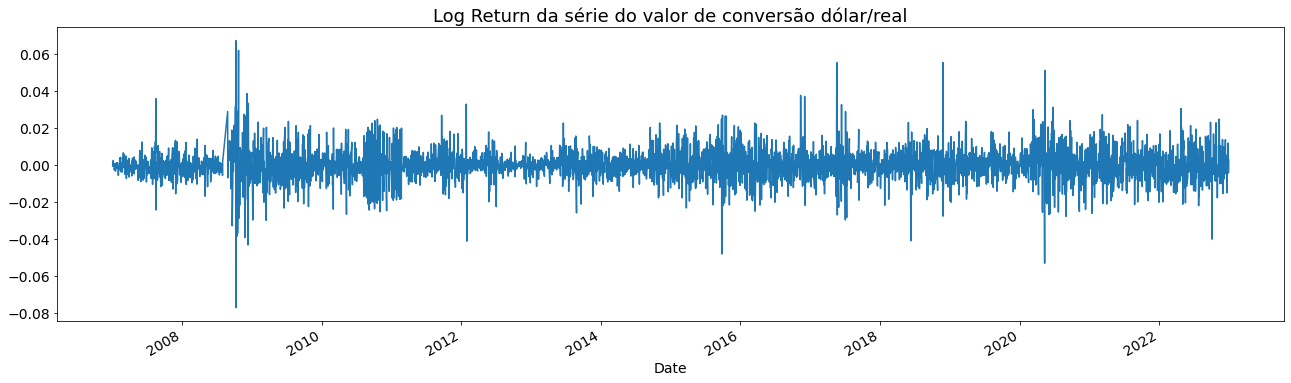

In [39]:
_ = serie_dolar.Close.apply(np.log1p).diff().plot(title="Log Return da série do valor de conversão dólar/real")

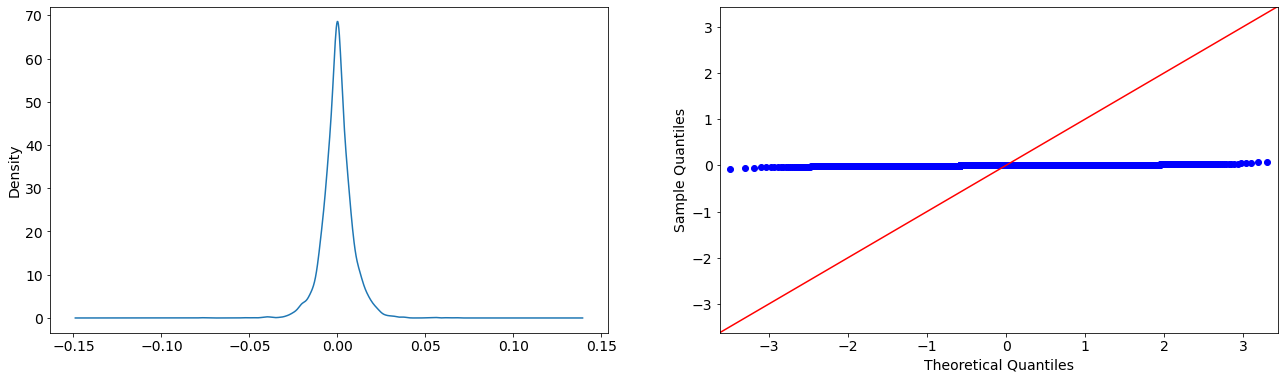

In [40]:
fig, axs = plt.subplots(1,2)
_ = serie_dolar.Close.apply(np.log1p).diff().plot(kind="kde", ax=axs[0])
sm.qqplot(serie_dolar.Close.apply(np.log1p).diff(), line ='45', ax=axs[1])
plt.show()

In [41]:
stat, p = stats.shapiro(serie_dolar.Close.apply(np.log1p).diff()[1:])

resultado_shapiro(stat, p)

Statistics=0.943, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

---

### Removendo Sazonalidade (por diferenciação)

#### Aplicando diferenciação de 30 dias

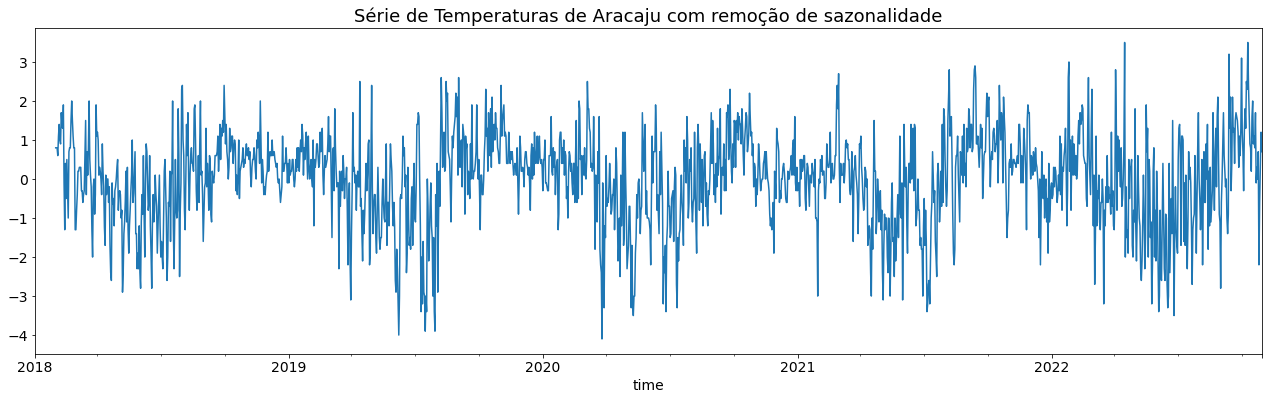

In [42]:
_ = serie_aracaju.tavg.diff(30).plot(title="Série de Temperaturas de Aracaju com remoção de sazonalidade")

Para remover o que resta de tendência, pode-se aplicar novamente uma
diferenciação simples.

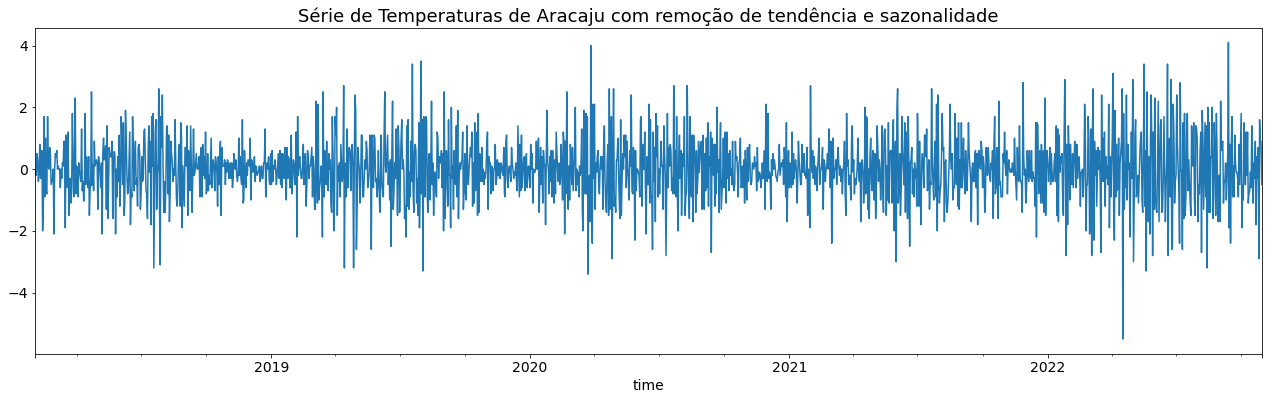

In [43]:
serie_aracaju_diferenciada_30 = serie_aracaju.tavg.diff(30).diff().iloc[31:]
_ = serie_aracaju_diferenciada_30.plot(title="Série de Temperaturas de Aracaju com remoção de tendência e sazonalidade")

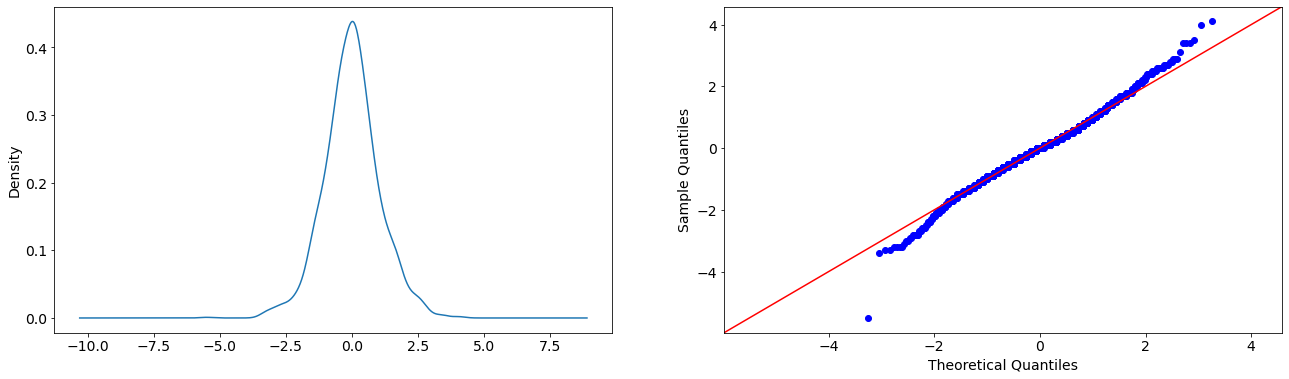

In [44]:
fig, axs = plt.subplots(1,2)
_ = serie_aracaju_diferenciada_30.plot(kind="kde", ax=axs[0])
sm.qqplot(serie_aracaju_diferenciada_30, line ='45', ax=axs[1])
plt.show()

In [45]:
stat, p = stats.shapiro(serie_aracaju_diferenciada_30)

resultado_shapiro(stat, p)

Statistics=0.990, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

#### Aplicando diferenciação de 365 dias

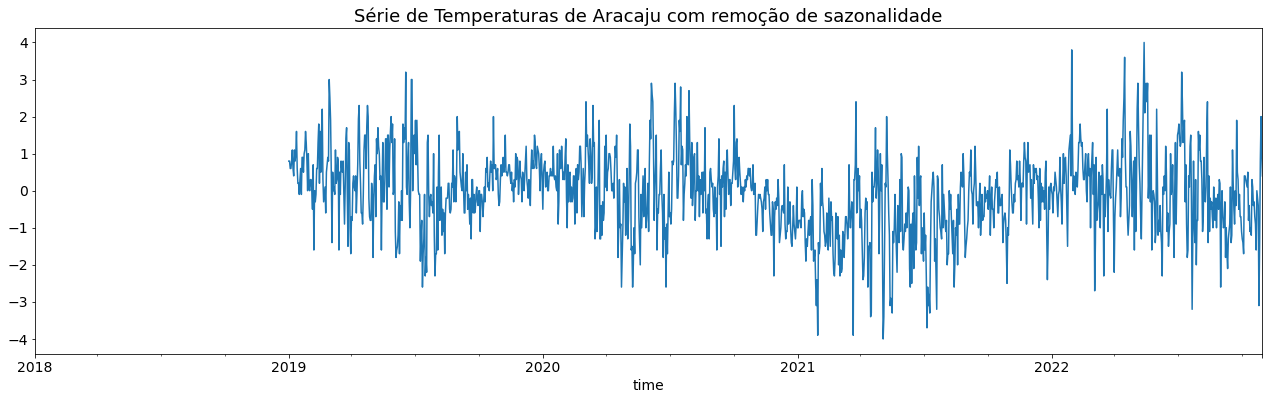

In [46]:
_ = serie_aracaju.tavg.diff(365).plot(title="Série de Temperaturas de Aracaju com remoção de sazonalidade")

Para remover o que resta de tendência, pode-se aplicar novamente uma
diferenciação simples.

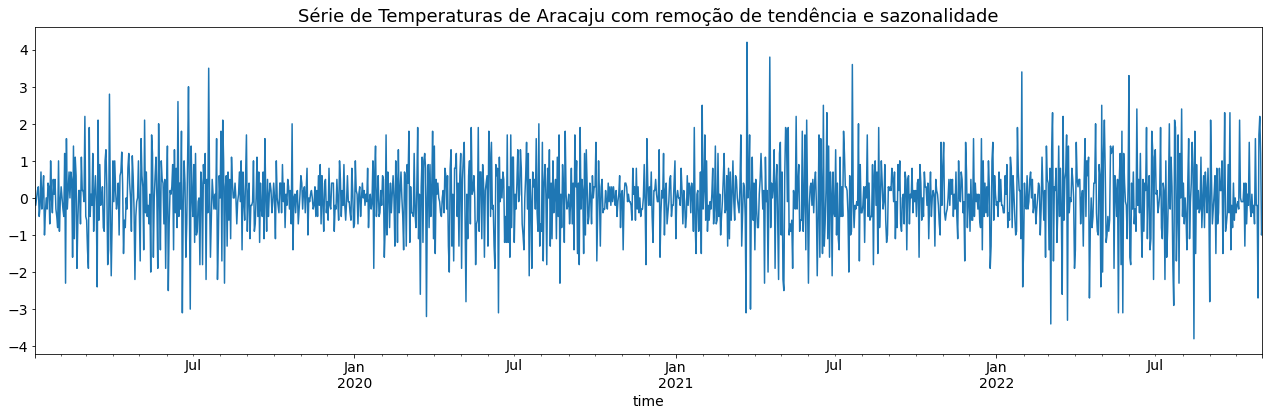

In [47]:
serie_aracaju_diferenciada_365 = serie_aracaju.tavg.diff(365).diff().iloc[366:]
_ = serie_aracaju_diferenciada_365.plot(title="Série de Temperaturas de Aracaju com remoção de tendência e sazonalidade")

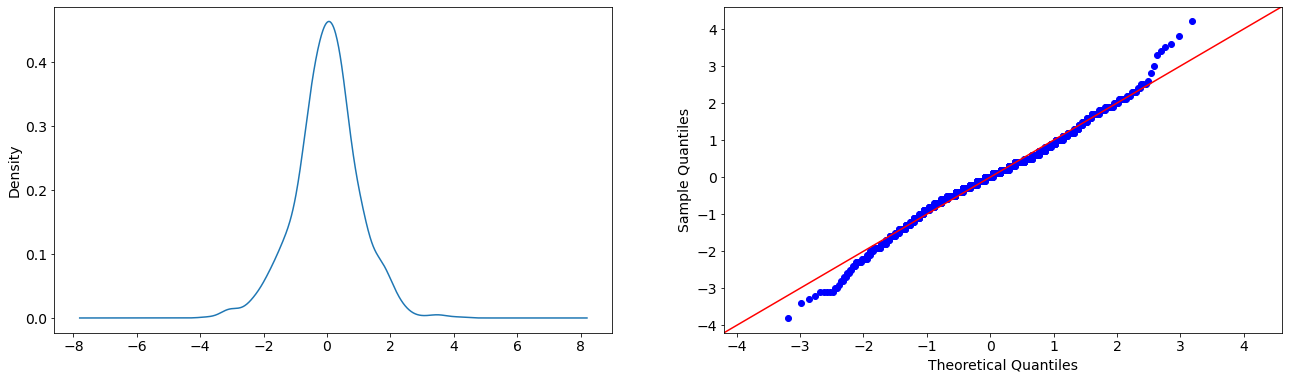

In [49]:
fig, axs = plt.subplots(1,2)
_ = serie_aracaju_diferenciada_365.plot(kind="kde", ax=axs[0])
sm.qqplot(serie_aracaju_diferenciada_365, line ='45', ax=axs[1])
plt.show()

In [50]:
stat, p = stats.shapiro(serie_aracaju_diferenciada_365)

resultado_shapiro(stat, p)

Statistics=0.988, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

#### Combinando as diferenciações
Podemos também, combinar as duas diferenciações, de 365 e 30 dias.

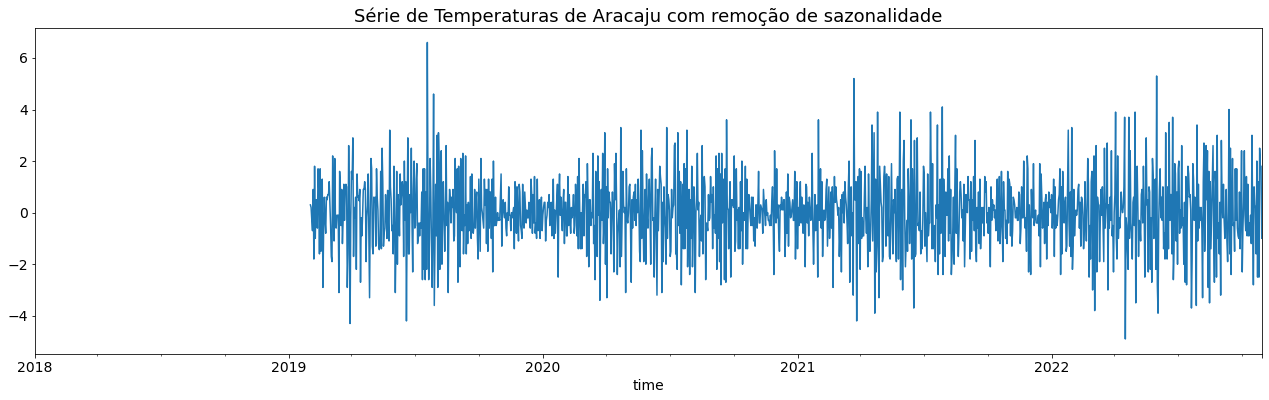

In [51]:
_ = serie_aracaju.tavg.diff(365).diff(30).diff().plot(title="Série de Temperaturas de Aracaju com remoção de sazonalidade")

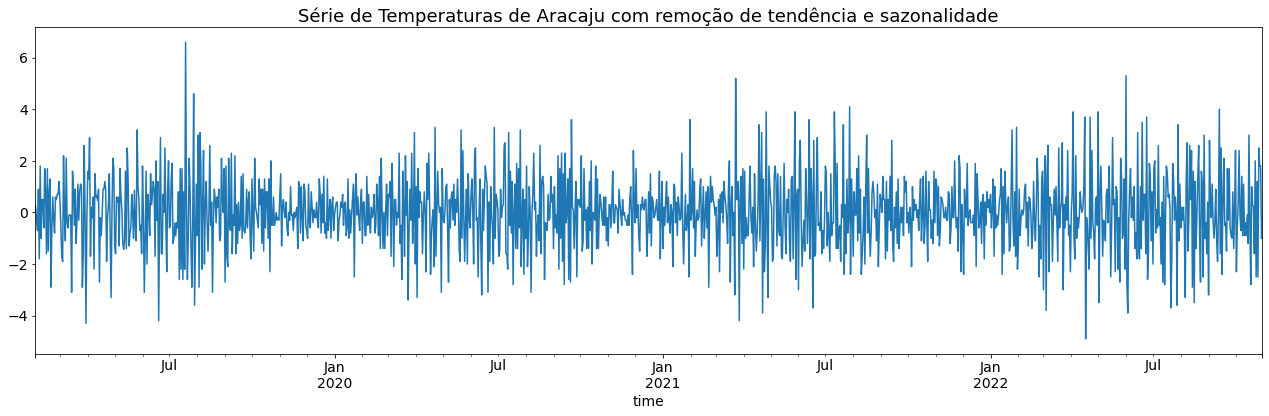

In [52]:
serie_aracaju_diferenciada_365_30 = serie_aracaju.tavg.diff(365).diff(30).diff().iloc[396:]
_ = serie_aracaju_diferenciada_365_30.plot(title="Série de Temperaturas de Aracaju com remoção de tendência e sazonalidade")

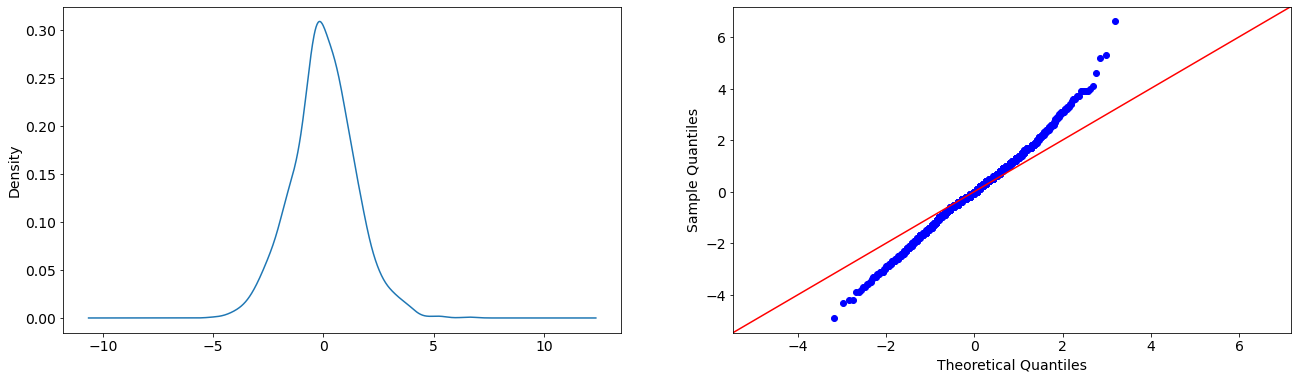

In [53]:
fig, axs = plt.subplots(1,2)
_ = serie_aracaju_diferenciada_365_30.plot(kind="kde", ax=axs[0])
sm.qqplot(serie_aracaju_diferenciada_365_30, line ='45', ax=axs[1])
plt.show()

In [54]:
stat, p = stats.shapiro(serie_aracaju_diferenciada_365_30)

resultado_shapiro(stat, p)

Statistics=0.995, p-valor=0.00008099

**A amostra não parece Gaussiana (rejeitamos H0)**

O que acontece se continuarmos diferenciando?

In [55]:
stat, p = stats.shapiro(serie_aracaju_diferenciada_365_30.diff()[1:])

resultado_shapiro(stat, p)

Statistics=0.998, p-valor=0.04047272

**A amostra não parece Gaussiana (rejeitamos H0)**

In [56]:
stat, p = stats.shapiro(serie_aracaju_diferenciada_365_30.diff().diff()[2:])

resultado_shapiro(stat, p)

Statistics=0.998, p-valor=0.08136015

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

### Exercício

1. Exiba as diferenciações da série de temperatura da sua cidade e realize os testes de normalidade.
2. Exiba as diferenciações das séries de câmbio dólar/real, euro/real e dólar/yuan chinês e realize os testes de normalidade.